In [2]:
import pandas as pd
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)


#Load the data
df = pd.read_csv('https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')
df.ds = pd.to_datetime(df.ds)
df.tail()

Importing plotly failed. Interactive plots will not work.


,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,AMBVERT1,AMBVERTTBS,QTrack_TBS,Garage_TBS,RAZ_CONS_MORE2H,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM
35140,2025-01-06 16:00:00,12,120,4,85,16,205,6,29,0,...,14,12,4.0,0.0,13,0,1,1,15,11
35141,2025-01-06 17:00:00,14,134,6,91,20,225,1,30,0,...,18,18,6.0,0.0,11,0,1,1,15,12
35142,2025-01-06 18:00:00,10,144,5,96,15,240,1,31,0,...,19,18,9.0,0.0,8,0,1,0,18,13
35143,2025-01-06 19:00:00,11,155,7,103,18,258,3,34,0,...,23,20,11.0,0.0,11,0,2,3,17,12
35144,2025-01-06 20:00:00,8,163,8,111,16,274,2,36,1,...,23,19,15.0,0.0,10,0,3,3,17,12


In [56]:
#Create a dataframe called dailyVisits with the columns ds and y, where ds is the date and y is the the value of the column 'Inflow_Cum_Total' at midnight of the following day
dailyVisits = df[['ds', 'Inflow_Cum_Total']].copy()
dailyVisits.columns = ['ds', 'y']
# dailyVisits.ds = dailyVisits.ds + pd.DateOffset(days=1)
dailyVisits.y = dailyVisits.y.shift(-1)
dailyVisits = dailyVisits.dropna()

#filter dailyVisits to only include rows where the hour of the timestamp in column ds is 0
dailyVisits = dailyVisits[dailyVisits.ds.dt.hour == 23]
dailyVisits.ds = dailyVisits.ds.dt.date

dailyVisits.tail()

,ds,y
34595,2024-12-14,216.0
34619,2024-12-15,194.0
34643,2024-12-16,291.0
34667,2024-12-17,260.0
34691,2024-12-18,253.0


In [55]:
qc_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='CA', province='QC'
)
qc_holidays

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-04-19,Good Friday
2,2019-07-01,Canada Day
3,2019-09-02,Labor Day
4,2019-12-25,Christmas Day
...,...,...
81,2028-09-04,Labor Day
82,2028-12-25,Christmas Day
83,2028-05-22,National Patriots' Day
84,2028-06-24,St. John the Baptist Day


In [22]:
ramq_holidays = pd.read_csv('ramq_holidays.csv')
ramq_holidays.ds = pd.to_datetime(ramq_holidays.ds)
ramq_holidays

,ds,holiday
0,2024-05-20,Journée nationale des Patriotes
1,2024-06-24,Fête nationale du Québec
2,2024-07-01,Fête du Canada
3,2024-09-02,Fête du Travail
4,2024-10-14,Action de grâces
...,...,...
85,2019-12-31,Veille du jour de l'An
86,2020-01-01,Jour de l'An
87,2019-10-09,Lendemain du jour de l'An
88,2020-04-10,Vendredi saint


In [21]:
pd.concat([qc_holidays, ramq_holidays])

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-04-19,Good Friday
2,2019-07-01,Canada Day
3,2019-09-02,Labor Day
4,2019-12-25,Christmas Day
...,...,...
85,2019-12-31,Veille du jour de l'An
86,2020-01-01,Jour de l'An
87,2019-10-09,Lendemain du jour de l'An
88,2020-04-10,Vendredi saint


In [24]:
# Use prophet to forecast the number of visits for the next 30 days
m = prophet.Prophet(holidays=pd.concat([qc_holidays, ramq_holidays]))
m.add_country_holidays(country_name='CA')
m.add_country_holidays(country_name='IL')

m.fit(dailyVisits)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


Changing country holidays from 'CA' to 'IL'.


21:49:03 - cmdstanpy - INFO - Chain [1] start processing
21:49:03 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1473,2025-01-14,270.543126,225.642494,318.427067
1474,2025-01-15,273.030435,226.027107,320.155695
1475,2025-01-16,265.504483,219.830371,313.312045
1476,2025-01-17,259.208531,214.107795,310.113252
1477,2025-01-18,261.586749,214.714921,308.487256


In [27]:
#Calculate the RMSE of the forecast
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

df_cv = cross_validation(m, initial='1000 days', period='180 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/3 [00:00<?, ?it/s]

21:51:18 - cmdstanpy - INFO - Chain [1] start processing
21:51:18 - cmdstanpy - INFO - Chain [1] done processing
21:51:19 - cmdstanpy - INFO - Chain [1] start processing
21:51:19 - cmdstanpy - INFO - Chain [1] done processing
21:51:19 - cmdstanpy - INFO - Chain [1] start processing
21:51:19 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,3461.6352,58.835663,51.18274,0.251877,0.131765,0.305856,0.666667


In [36]:
m = prophet.Prophet()
m.fit(dailyVisits)
df_cv = cross_validation(m, initial='1000 days', period='8 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

23:14:56 - cmdstanpy - INFO - Chain [1] start processing
23:14:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/56 [00:00<?, ?it/s]

23:14:56 - cmdstanpy - INFO - Chain [1] start processing
23:14:56 - cmdstanpy - INFO - Chain [1] done processing
23:14:56 - cmdstanpy - INFO - Chain [1] start processing
23:14:56 - cmdstanpy - INFO - Chain [1] done processing
23:14:56 - cmdstanpy - INFO - Chain [1] start processing
23:14:56 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1] done processing
23:14:58 - cmdstanpy - INFO - Chain [1] start processing
23:14:58 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,2913.46143,53.97649,36.811253,2.075661,0.106227,0.216036,0.767857


In [37]:
m = prophet.Prophet()
m.add_country_holidays(country_name='IL')
m.fit(dailyVisits)
df_cv = cross_validation(m, initial='1000 days', period='8 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

23:15:20 - cmdstanpy - INFO - Chain [1] start processing
23:15:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/56 [00:00<?, ?it/s]

23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:22 - cmdstanpy - INFO - Chain [1] start processing
23:15:22 - cmdstanpy - INFO - Chain [1] done processing
23:15:23 - cmdstanpy - INFO - Chain [1] start processing
23:15:23 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,2829.957281,53.197343,35.754629,2.055438,0.105867,0.211877,0.803571


In [47]:
m = prophet.Prophet()
m.add_country_holidays(country_name='CA')
m.fit(dailyVisits)
df_cv = cross_validation(m, initial='1083 days', period='1 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/364 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1275.935974,35.720246,27.883966,0.107928,0.080801,0.113551,0.826923


In [58]:
m = Prophet(holidays=ramq_holidays)
m.fit(dailyVisits)
df_cv = cross_validation(m, initial='1083 days', period='1 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/364 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1261.398603,35.516174,27.425517,0.105954,0.077957,0.111333,0.832418


In [62]:
365*2

730

In [64]:
m = Prophet()
m.fit(dailyVisits.tail(365*2))
df_cv = cross_validation(m, initial='365 days', period='1 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/364 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1074.9762,32.78683,25.607867,0.098374,0.087273,0.099698,0.975275


In [46]:
m = prophet.Prophet(holidays=qc_holidays)
m.fit(dailyVisits)
df_cv = cross_validation(m, initial='1083 days', period='1 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/364 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1276.447748,35.727409,27.848062,0.107786,0.078402,0.113474,0.824176


In [48]:
m = prophet.Prophet()
m.add_country_holidays(country_name='IL')
m.fit(dailyVisits)
df_cv = cross_validation(m, initial='1083 days', period='1 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/364 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1256.237921,35.443447,27.5356,0.106222,0.082303,0.111381,0.832418


In [50]:
m = Prophet(holidays=ramq_holidays)
m.add_country_holidays(country_name='IL')
m.fit(dailyVisits)
df_cv = cross_validation(m, initial='1083 days', period='1 days', horizon='1 day')
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/364 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1269.158873,35.625256,27.760204,0.107196,0.080959,0.112507,0.82967


In [51]:
m.train_holiday_names


0     Journée nationale des Patriotes
1            Fête nationale du Québec
2                      Fête du Canada
3                     Fête du Travail
4                    Action de grâces
5                      Veille de Noël
6                        Fête de Noël
7                   Lendemain de Noël
8              Veille du jour de l'An
9                        Jour de l'An
10          Lendemain du jour de l'An
11                     Vendredi saint
12                    Lundi de Pâques
13                      Rosh Hashanah
14                         Yom Kippur
15                             Sukkot
16    Simchat Torah / Shemini Atzeret
17                             Pesach
18              Seventh day of Pesach
19        Independence Day (observed)
20                            Shavuot
21                   Independence Day
dtype: object

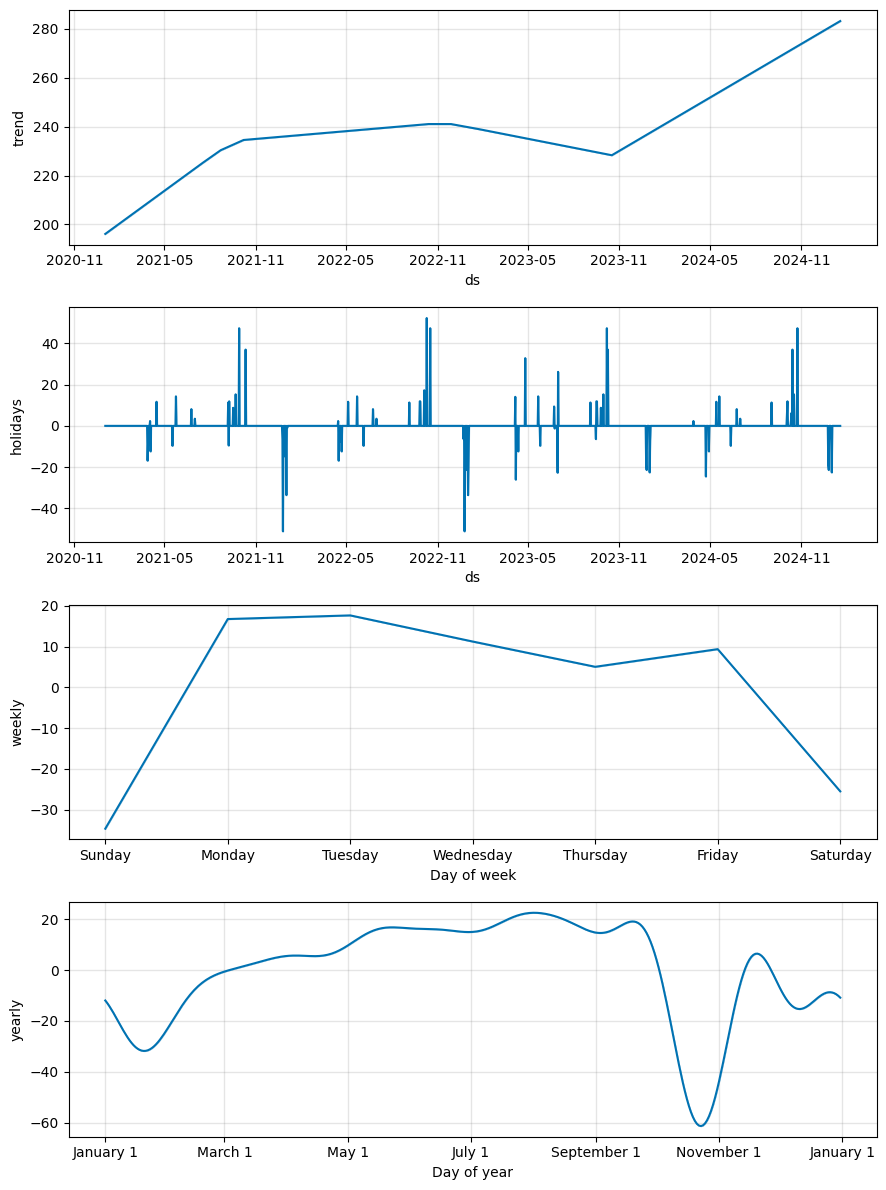

In [59]:
fig2 = m.plot_components(forecast)


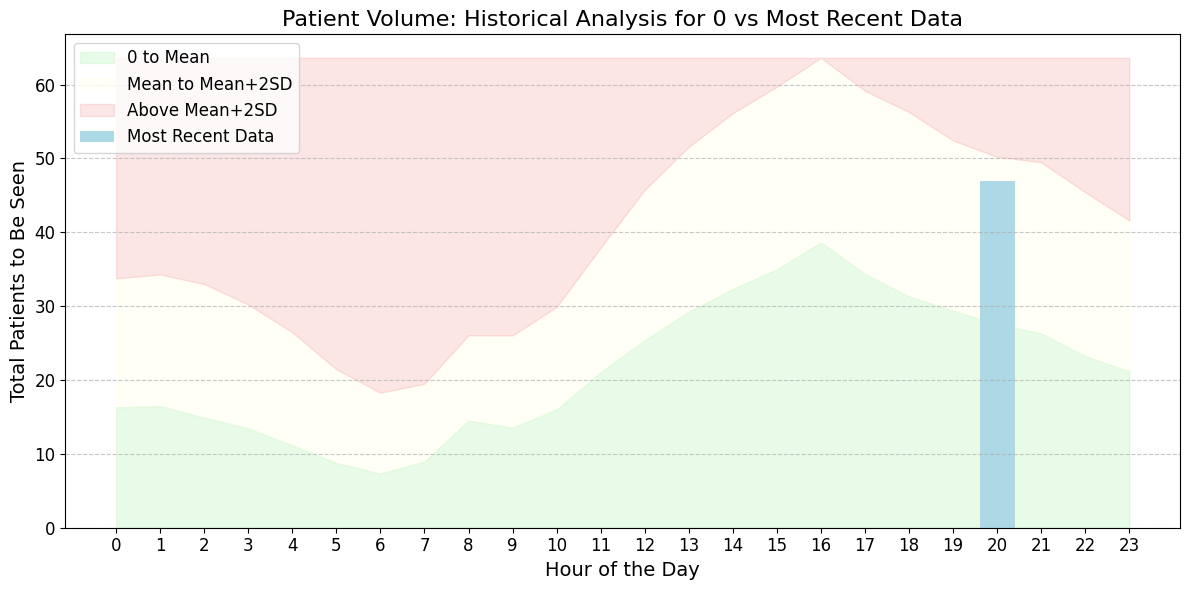

In [3]:
import matplotlib.pyplot as plt



data = pd.read_csv('https://www.dropbox.com/scl/fi/ksf0nbmmiort5khbrgr61/allData.csv?rlkey=75e735fjk4ifttjt553ukxt3k&dl=1')

# Calculate total patients to be seen as the sum of specified columns
data['Total_Patients_To_Be_Seen'] = (
    data['TRG_HALLWAY_TBS'] + 
    data['POD_GREEN_TBS'] + 
    data['POD_YELLOW_TBS'] + 
    data['POD_ORANGE_TBS'] + 
    data['RAZ_TBS'] + 
    data['AMBVERTTBS'] + 
    data['QTrack_TBS'] + 
    data['Garage_TBS']
)

# Extract the timestamp and determine the most recent
data['Timestamp'] = pd.to_datetime(data['ds'])
most_recent_timestamp = data['Timestamp'].iloc[-1]
most_recent_hour = most_recent_timestamp.hour
most_recent_value = data.loc[data['Timestamp'] == most_recent_timestamp, 'Total_Patients_To_Be_Seen'].iloc[0]

# Extract day of the week and filter for the same day as the most recent timestamp
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
most_recent_day_of_week = most_recent_timestamp.dayofweek
same_day_data = data[data['DayOfWeek'] == most_recent_day_of_week]

# Group by hour and calculate the mean and standard deviation for each hour
hourly_data_same_day = same_day_data.groupby(data['Timestamp'].dt.hour)['Total_Patients_To_Be_Seen'].mean()
hourly_std_same_day = same_day_data.groupby(data['Timestamp'].dt.hour)['Total_Patients_To_Be_Seen'].std()

# Define thresholds for coloring
light_green_limit = hourly_data_same_day
light_yellow_limit = hourly_data_same_day + 2 * hourly_std_same_day

# Plot the updated graph with colored areas
plt.figure(figsize=(12, 6))

# Fill areas for different zones
plt.fill_between(hourly_data_same_day.index, 0, light_green_limit, color='lightgreen', alpha=0.2, label='0 to Mean')
plt.fill_between(hourly_data_same_day.index, light_green_limit, light_yellow_limit, color='lightyellow', alpha=0.2, label='Mean to Mean+2SD')
plt.fill_between(hourly_data_same_day.index, light_yellow_limit, max(light_yellow_limit.max(), most_recent_value), color='lightcoral', alpha=0.2, label='Above Mean+2SD')

# Add the most recent data as a red bar
plt.bar(
    most_recent_hour, most_recent_value, color='lightblue', alpha=1, label='Most Recent Data'
)

# Add labels and legend
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Total Patients to Be Seen', fontsize=14)
plt.title(f'Patient Volume: Historical Analysis for {most_recent_day_of_week} vs Most Recent Data', fontsize=16)
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
